In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse.linalg
import scipy.sparse as sp
import matplotlib.pyplot as plt
import time
%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "../../data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

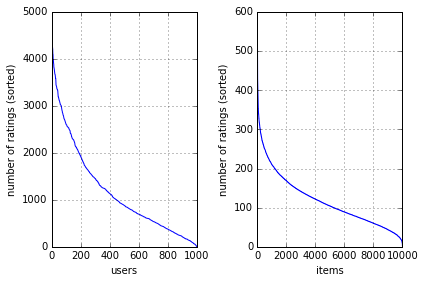

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
import math

def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(986)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    I, J, V = sp.find(valid_ratings)
    
    all_indices = np.arange(I.shape[0])
    print(all_indices)
    test_size = math.ceil(I.shape[0]*p_test)
    np.random.shuffle(all_indices)
    test_indices = all_indices[:test_size]
    train_indices = np.delete(all_indices, test_indices, axis=0)

    I_train = I[train_indices]
    J_train = J[train_indices]
    V_train = V[train_indices]
    
    I_test = I[test_indices]
    J_test = J[test_indices]
    V_test = V[test_indices]
    
    test = sp.lil_matrix(sp.coo_matrix((V_test, (I_test, J_test)), (valid_ratings.shape)))
    train = sp.lil_matrix(sp.coo_matrix((V_train, (I_train, J_train)), (valid_ratings.shape)))

    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data and return train and test data. TODO
    # NOTE: we only consider users and movies that have more
    # than 10 ratings
    # ***************************************************
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in valid data:{v}".format(v=valid_ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

[      0       1       2 ..., 1176949 1176950 1176951]
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in valid data:1176952
Total number of nonzero elements in train data:882714
Total number of nonzero elements in test data:294238


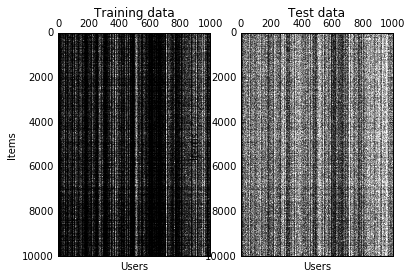

(10000, 1000)


In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.25)
plot_train_test_data(train, test)
print(train.shape)
#train = train.tocsr()
#test = test.tocsr()

### Learn the Matrix Factorization using Alternating Least Squares

In [6]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    train_c = sp.csr_matrix(train)
    W = 5 * np.random.rand(train_c.shape[0], num_features) # Film_features
    col_avg = train.sum(axis=1).A1 / np.diff(train_c.indptr)
    W[:,0] = col_avg
    Z = 5 * np.random.rand(train.shape[1], num_features)  # User_features

    return sp.csr_matrix(W), sp.csr_matrix(Z)


In [7]:
def update_user_feature(
        train, item_features, lambda_user,
        user_features, num_features, A_arr):
    """update user feature matrix."""
    train_c = sp.csr_matrix(train.T)
    for u in range(train.shape[1]):
        d = A_arr[u]
        A_i = sp.diags(d).tocsr()
        #print(A_i.shape, train.shape)
        user_features[u] = sp.linalg.spsolve(item_features.T.dot(A_i.dot(item_features)) +  lambda_user * 
                                             sp.eye(num_features), item_features.T.dot(A_i.dot(train_c[u].T)))

def update_item_feature(
        train, user_features, lambda_item,
        item_features, num_features, A_arr):
    """update item feature matrix."""
    train_c = sp.csr_matrix(train)
    for m in range(train.shape[0]):
        d = A_arr[m]
        A_i = sp.diags(d).tocsr()

        item_features[m] = sp.linalg.spsolve(user_features.T.dot(A_i.dot(user_features)) +  lambda_item * 
                                             sp.eye(num_features), user_features.T.dot(A_i.dot(train_c[m].T)))

In [16]:
def get_error(X, W, Z):
    predic = W.dot(Z.T)
    predic[predic < 1] = 1.
    predic[predic > 5] = 5.
    ctrain = sp.coo_matrix(X)
    error = 0
    n = 0
    for i,j,v in zip(ctrain.row, ctrain.col, ctrain.data):
        error += (v - predic[i, j]) ** 2
        n += 1
    return error/n

In [17]:
def ALS_pred(data, lambda_user, lambda_item, num_features):
    A = sp.csr_matrix(data)
    A[A > 0] = 1
    A_arr = A.toarray()

    # init ALS
    item_features, user_features = init_MF(data, num_features)
    for i in range(10):
        start = time.clock()
        print("Iteration ", i)
        update_user_feature(data, item_features, lambda_user, user_features, num_features, A_arr.T)
        update_item_feature(data, user_features, lambda_item, item_features, num_features, A_arr)
        stop = time.clock()
        print("One iteration in: ", stop-start, "s")
    return item_features, user_features

# Cross validation

### Cross validation for lambdas 

In [18]:
RMSE_test = []
RMSE_train = []
lambdas = [0.001, 0.005, 0.01, 0.05, 0.2, 0.5, 0.65, 0.8]
for lamb_ in lambdas:
    it, us = ALS_pred(train, lamb_, lamb_, 30)
    RMSE_test.append(np.sqrt(2* get_error(test, it, us)))
    RMSE_train.append(np.sqrt(2* get_error(train, it, us)))
np.save("rmse_test", RMSE_test)
np.save("rmse_train", RMSE_train)

Iteration  0
One iteration in:  67.81348700000001 s
Iteration  1
One iteration in:  63.93482499999999 s
Iteration  2
One iteration in:  63.499229000000014 s
Iteration  3
One iteration in:  63.627006999999935 s
Iteration  4
One iteration in:  63.418229 s
Iteration  5
One iteration in:  63.83998299999996 s
Iteration  6
One iteration in:  63.49392599999999 s
Iteration  7
One iteration in:  63.594336 s
Iteration  8
One iteration in:  63.49138900000003 s
Iteration  9
One iteration in:  63.57416999999998 s
Iteration  0
One iteration in:  63.47919000000002 s
Iteration  1
One iteration in:  63.690965000000006 s
Iteration  2
One iteration in:  63.46977500000003 s
Iteration  3
One iteration in:  63.62675899999999 s
Iteration  4
One iteration in:  63.50017100000014 s
Iteration  5
One iteration in:  63.50489999999991 s
Iteration  6
One iteration in:  63.43907899999999 s
Iteration  7
One iteration in:  63.52409199999988 s
Iteration  8
One iteration in:  63.570368000000144 s
Iteration  9
One iterati

In [19]:
RMSE_test_60 = []
RMSE_train_60 = []
for lamb_ in lambdas:
    it, us = ALS_pred(train, lamb_, lamb_, 60)
    RMSE_test_60.append(np.sqrt(2* get_error(test, it, us)))
    RMSE_train_60.append(np.sqrt(2* get_error(train, it, us)))
np.save("rmse_test_60", RMSE_test_60)
np.save("rmse_train_60", RMSE_train_60)

Iteration  0
One iteration in:  93.71410399999968 s
Iteration  1
One iteration in:  93.72124600000006 s
Iteration  2
One iteration in:  93.83129000000008 s
Iteration  3
One iteration in:  93.83040600000004 s
Iteration  4
One iteration in:  93.60863100000006 s
Iteration  5
One iteration in:  93.77749099999983 s
Iteration  6
One iteration in:  93.77808000000005 s
Iteration  7
One iteration in:  93.86521900000025 s
Iteration  8
One iteration in:  93.81442400000014 s
Iteration  9
One iteration in:  93.61102299999948 s
Iteration  0
One iteration in:  93.68225100000018 s
Iteration  1
One iteration in:  93.91415899999993 s
Iteration  2
One iteration in:  93.80720400000064 s
Iteration  3
One iteration in:  93.64506100000017 s
Iteration  4
One iteration in:  93.82727900000009 s
Iteration  5
One iteration in:  93.62162399999943 s
Iteration  6
One iteration in:  93.72318499999983 s
Iteration  7
One iteration in:  93.66979100000026 s
Iteration  8
One iteration in:  93.63262299999951 s
Iteration  9

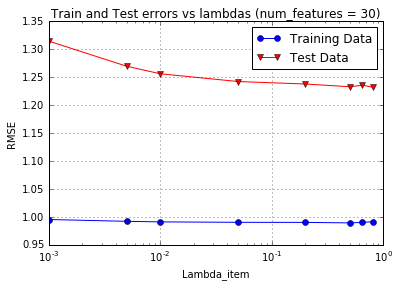

In [7]:
lambdas = [0.001, 0.005, 0.01, 0.05, 0.2, 0.5, 0.65, 0.8]
rmse_test = np.load('./saved_rmses/rmse_test.npy')
rmse_train = np.load('./saved_rmses/rmse_train.npy')
plt.plot(lambdas, rmse_train, marker='o', label='Training Data');
plt.plot(lambdas, rmse_test, marker='v', label='Test Data', color='r');
plt.title('Train and Test errors vs lambdas (num_features = 30)')
plt.xlabel('Lambda_item');
plt.ylabel('RMSE');
plt.xscale('log')
plt.legend()
plt.grid()
plt.savefig('rmse_vs_lambdas_item_als_30')
plt.show()

In [5]:
from mf_als import run_mf_reg_cv
rmse_tr, rmse_te = run_mf_reg_cv(ratings, 4, 60, 0.65, 0.65)

Iteration  0
One iteration in:  98.323531 s
Iteration  1
One iteration in:  100.28720899999999 s
Iteration  2
One iteration in:  100.22799200000003 s
Iteration  3
One iteration in:  101.02789200000001 s
Iteration  4
One iteration in:  99.63917600000002 s
Iteration  5
One iteration in:  104.43216799999993 s
Iteration  6
One iteration in:  96.69275300000004 s
Iteration  7
One iteration in:  97.73034700000005 s
Iteration  8
One iteration in:  97.7988069999999 s
Iteration  9
One iteration in:  97.26009099999999 s


/home/huguenin/anaconda3/lib/python3.5/site-packages/scipy/sparse/compressed.py:275: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


Iteration  0
One iteration in:  97.24345400000016 s
Iteration  1
One iteration in:  99.33374600000002 s
Iteration  2
One iteration in:  98.26578499999982 s
Iteration  3
One iteration in:  98.10575199999994 s
Iteration  4
One iteration in:  96.38965499999995 s
Iteration  5
One iteration in:  96.35341699999981 s
Iteration  6
One iteration in:  96.16636400000016 s
Iteration  7
One iteration in:  96.2814350000001 s
Iteration  8
One iteration in:  96.31406000000015 s
Iteration  9
One iteration in:  96.71979399999987 s
Iteration  0
One iteration in:  96.17978200000016 s
Iteration  1
One iteration in:  96.03353000000016 s
Iteration  2
One iteration in:  95.96932000000015 s
Iteration  3
One iteration in:  95.94186600000012 s
Iteration  4
One iteration in:  96.02210500000001 s
Iteration  5
One iteration in:  96.01319000000012 s
Iteration  6
One iteration in:  96.01134200000024 s
Iteration  7
One iteration in:  96.11158699999987 s
Iteration  8
One iteration in:  95.97552099999984 s
Iteration  9


In [15]:
np.mean(rmse_tr)

0.65154895256419021

# Compute predictions

In [143]:
lambda_user = 0.01
lambda_item = 0.02
num_features = 50
data = ratings

In [144]:
def ALS_pred(data, lambda_user, lambda_item, num_features):
    A = sp.csr_matrix(data)
    A[A > 0] = 1
    A_arr = A.toarray()

    # init ALS
    item_features, user_features = init_MF(data, num_features)
    for i in range(9):
        start = time.clock()
        print("Iteration ", i)
        update_user_feature(data, item_features, lambda_user, user_features, num_features, A_arr.T)
        update_item_feature(data, user_features, lambda_item, item_features, num_features, A_arr)
        stop = time.clock()
        print("One iteration in: ", stop-start, "s")
    return item_features, user_features

In [145]:
W, Z = ALS_pred(data, lambda_user, lambda_item, num_features)
print(np.sqrt(2 * get_error(data, W, Z)))

Iteration  0
0.01114899999993213
0.03439600000092469
0.012052999998559244
0.06430299999919953
0.016823999998450745
0.047260999999707565
0.04593100000056438
0.022698000000673346
0.02012299999842071
0.010339999998905114
0.0054139999992912635
0.007057000000713742
0.006310999999186606
0.00713999999970838
0.005440999999336782
0.006798000000344473
0.006309000000328524
0.007190000000264263
0.005746999999246327
0.006589000000531087
One iteration in:  99.5013289999988 s
Iteration  1
0.011029999999664142
0.03444800000033865
0.010850000000573345
0.06451100000049337
0.01688800000010815
0.045744000000922824
0.045973999998750514
0.022086000000854256
0.02343300000029558
0.010576999999102554
0.004935000000841683
0.007136000000173226
0.006354999999530264
0.008138000001054024
0.0053079999997862615
0.007030000000668224
0.006541999999171821
0.007510999999794876
0.005662999999913154
0.006729999999151914
One iteration in:  100.00305500000104 s
Iteration  2
0.011694000000716187
0.034369999999398715
0.0106569

In [147]:
X_pred = W.dot(Z.T)
print(X_pred.shape)

(10000, 1000)


# 4) Make submission

In [148]:
from collections import deque
import datetime
from helpers import *
now = datetime.datetime.now()
now_str = now.strftime("%d-%m-%Y_%Hh%M_%S")
output_path = '../data/predictions-%s-group-clm.csv' % now_str

indices = extract_indices('../data/sampleSubmission.csv')

ratings_to_write = deque()
for row, col in indices:
    ratings_to_write.append((row, col, X_pred[row,col]))
    
create_csv_submission(ratings_to_write, output_path)

999   0
